In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!source /content/drive/MyDrive/colab_env/bin/activate

import sys
sys.path.append("/content/drive/MyDrive/colab_env/lib/python3.10/site-packages")

In [ ]:
# !pip install dataframe_image

In [ ]:
!pip install transformers==4.30.2
# print(transformers.__version__)  ## 4.30.2

In [43]:
import locale
locale.getpreferredencoding = lambda: "UTF-8"

In [5]:
import os
import re
import json
import emoji
import spacy
import pandas as pd
import transformers
from io import StringIO
import spacy_transformers
# import dataframe_image as dfi
import matplotlib.pyplot as plt
from spacy.tokens import DocBin
from spacy.training import Example
from sklearn.model_selection import train_test_split
from spacy.pipeline.textcat_multilabel import Config, multi_label_cnn_config

In [ ]:
emoji_list = emoji.EMOJI_DATA

In [13]:
%config InlineBackend.figure_format = 'retina'

In [6]:
def get_json(file_path):
    with open(file_path, 'r', encoding = 'utf-8') as file:
        content = json.load(file, strict = False)
    return content

In [14]:
def rmemoji(text):
    return emoji.replace_emoji(text, '').strip()

def emoji2description(text):
    return emoji.replace_emoji(text, replace = lambda chars, data_dict: ' ' + ' '.join(data_dict['zh'].split('_')).strip(':') + ' ')

def remove_punctuation_regex(input_string):
    return re.sub(r'[^\w\s]', '', input_string)

In [ ]:
!python -m spacy download zh_core_web_trf  ## Blank model ## Only Download when opening a new task

In [16]:
os.chdir('/content/drive/MyDrive/Capstone/Spacy/data')

### Raw dataset

In [17]:
df = pd.read_csv('Game_Layer_topic.csv')

### df_rmemoji / df_emoji2desc / df_rmpunc

#### df_rmemoji

In [18]:
df_rmemoji = df.copy()

print(len(df_rmemoji))
df_rmemoji['text'] = df_rmemoji['text'].astype(str).apply(rmemoji)
df_rmemoji['text'] = df_rmemoji['text'].replace(' ', '')
df_rmemoji = df_rmemoji[(df_rmemoji['text'] != '') & (df_rmemoji['text'].notnull())]
print(len(df_rmemoji))

63638
60058


#### df_emoji2desc

In [19]:
df_emoji2desc = df.copy()

print(len(df_emoji2desc))
df_emoji2desc['text'] = df_emoji2desc['text'].astype(str).apply(emoji2description)
df_emoji2desc['text'] = df_emoji2desc['text'].replace(' ', '')
df_emoji2desc = df_emoji2desc[(df_emoji2desc['text'] != '') & (df_emoji2desc['text'].notnull())]
print(len(df_emoji2desc))

63638
63638


#### df_rmpunc

In [20]:
df_rmpunc = df.copy()

print(len(df_rmpunc))
df_rmpunc['text'] = df_rmpunc['text'].astype(str).apply(remove_punctuation_regex)
df_rmpunc['text'] = df_rmpunc['text'].replace(' ','')
df_rmpunc = df_rmpunc[(df_rmpunc['text'] != '') & (df_rmpunc['text'].notnull())]
print(len(df_rmpunc))

63638
60057


In [21]:
spacy.prefer_gpu()
nlp = spacy.load('zh_core_web_trf')

In [22]:
y = df[['球員', '教練', '裁判', '戰術', '球隊']]
y = y.to_dict('index')

dataset = list(zip(df['text'],[{'cats': cats} for cats in y.values()]))

In [23]:
dataset[0]

('小温加油！美津濃加油🔥🔥', {'cats': {'球員': 1, '教練': 0, '裁判': 0, '戰術': 0, '球隊': 1}})

In [24]:
train_df, test_df = train_test_split(df, train_size = 0.7, random_state = 42)
train_data, test_data = train_test_split(dataset, train_size = 0.7, random_state = 42)

找出 df_rmemoji 和 df_emoji2desc 有在 test set 裡面的

In [25]:
ind = list(test_df['Unnamed: 0'])

In [26]:
df_rmemoji = df_rmemoji[df_rmemoji['Unnamed: 0'].isin(ind)]
df_emoji2desc = df_emoji2desc[df_emoji2desc['Unnamed: 0'].isin(ind)]
df_rmpunc = df_rmpunc[df_rmpunc['Unnamed: 0'].isin(ind)]

In [27]:
y_rmemoji = df_rmemoji[['球員', '教練', '裁判', '戰術', '球隊']]
y_rmemoji = y_rmemoji.to_dict('index')

dataset_rmemoji = list(zip(df_rmemoji['text'],[{'cats': cats} for cats in y_rmemoji.values()]))

In [28]:
dataset_rmemoji[0]

('阿甘真的加了', {'cats': {'球員': 1, '教練': 0, '裁判': 0, '戰術': 0, '球隊': 0}})

In [29]:
y_emoji2desc = df_emoji2desc[['球員', '教練', '裁判', '戰術', '球隊']]
y_emoji2desc = y_emoji2desc.to_dict('index')

dataset_emoji2desc = list(zip(df_emoji2desc['text'],[{'cats': cats} for cats in y_emoji2desc.values()]))

In [30]:
dataset_emoji2desc[0]

('阿甘真的加了', {'cats': {'球員': 1, '教練': 0, '裁判': 0, '戰術': 0, '球隊': 0}})

In [31]:
y_rmpunc = df_rmpunc[['球員', '教練', '裁判', '戰術', '球隊']]
y_rmpunc = y_rmpunc.to_dict('index')

dataset_rmpunc = list(zip(df_rmpunc['text'],[{'cats': cats} for cats in y_rmpunc.values()]))

In [32]:
dataset_rmpunc[0]

('阿甘真的加了', {'cats': {'球員': 1, '教練': 0, '裁判': 0, '戰術': 0, '球隊': 0}})

In [33]:
config = Config().from_str(multi_label_cnn_config)

text_cat = nlp.add_pipe("textcat_multilabel", config = config)

labels = ['球員', '教練', '裁判', '戰術', '球隊']

for i in labels:
    text_cat.add_label(i)

In [34]:
def make_docs(data):
    docs = []
    for text, annotations in data:
        if isinstance(text, str) and isinstance(annotations, dict):
            doc = nlp.make_doc(text)
            doc.cats = annotations.get("cats", {})
            docs.append(doc)
        else:
            print(f"Ignoring invalid data: {text}, {annotations}")
    return docs

In [35]:
os.chdir('/content/drive/MyDrive/Capstone/Spacy/Game_Layer')

In [36]:
train_docs = make_docs(train_data[:])
doc_bin_train = DocBin(docs = train_docs)
doc_bin_train.to_disk("./data/train.spacy")

In [37]:
valid_docs = make_docs(test_data[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid.spacy")

In [38]:
valid_docs = make_docs(dataset_rmemoji[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid_rmemoji.spacy")

In [39]:
valid_docs = make_docs(dataset_emoji2desc[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid_emoji2desc.spacy")

In [40]:
valid_docs = make_docs(dataset_rmpunc[:])
doc_bin_valid = DocBin(docs = valid_docs)
doc_bin_valid.to_disk("./data/valid_rmpunc.spacy")

### Load base_config.cfg
https://spacy.io/usage/training

In [41]:
# !python -m spacy init fill-config ./base_config.cfg ./config.cfg

In [44]:
!python -m spacy train config.cfg --output ./output_game_1220 --gpu-id 0 --paths.train ./data/train.spacy --paths.dev ./data/valid.spacy

2023-12-20 05:18:51.878528: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 05:18:51.878586: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 05:18:51.880199: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 05:18:53.367785: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
✔ Created output directory: output_game_1220
ℹ Saving to output directory: output_game_1220
ℹ Using GPU: 0

=========================== Initializing pipeline ===========================
tokenizer_config.json: 100% 29.0/29.0 [00:00<00:00, 163

In [ ]:
nlp = spacy.load('./output_game_1215/model-last')

In [ ]:
# test = []
# for texts, annotation in test_data:
#     doc = nlp.make_doc(texts)
#     test.append(Example.from_dict(doc, annotation))

# score = nlp.evaluate(test)
# score

In [ ]:
text = train_data[300]
doc = nlp(text[0])
print(text)
print(doc.cats)

('連莊加油', {'cats': {'比賽': 1, '加油': 1, '轉播': 0, '球迷的聊天': 0}})
{'比賽': 0.9998175501823425, '加油': 0.9999419450759888, '轉播': 0.00037666643038392067, '球迷的聊天': 0.0009782917331904173}


In [51]:
text = """E,#,LOSS TRANSFORMER,LOSS TEXTCAT_MULTILABEL,CATS_SCORE,SCORE
0, 0, 1.01, 2.01, 47.14, 0.47
0, 200, 864.33, 79.23, 98.74, 0.99
0, 400, 126.15, 22.80, 99.46, 0.99
1, 600, 51.74, 11.27, 99.71, 1.00
1, 800, 37.46, 10.15, 99.49, 0.99
1, 1000, 32.57, 8.60, 99.73, 1.00
2, 1200, 20.12, 6.10, 99.58, 1.00
2, 1400, 11.76, 6.74, 99.57, 1.00
2, 1600, 13.77, 6.33, 99.59, 1.00
3, 1800, 12.77, 5.40, 99.60, 1.00
3, 2000, 8.65, 3.71, 99.54, 1.00
4, 2200, 9.66, 4.95, 99.57, 1.00
4, 2400, 6.41, 4.41, 99.68, 1.00
4, 2600, 6.61, 4.64, 99.59, 1.00
"""


r = pd.read_csv(StringIO(text))

In [52]:
result = pd.DataFrame({
    'E': r['E'][:-1].reset_index(drop = True),
    '#': r['#'][:-1].reset_index(drop = True),
    'LOSS TRANSFORMER': r['LOSS TRANSFORMER'][1:].reset_index(drop = True),
    'LOSS TEXTCAT_MULTILABEL': r['LOSS TEXTCAT_MULTILABEL'][1:].reset_index(drop = True),
    'CATS_SCORE': r['CATS_SCORE'][:-1].reset_index(drop = True),
    'SCORE': r['SCORE'][:-1].reset_index(drop = True)
})

result

,E,#,LOSS TRANSFORMER,LOSS TEXTCAT_MULTILABEL,CATS_SCORE,SCORE
0,0,0,864.33,79.23,47.14,0.47
1,0,200,126.15,22.80,98.74,0.99
2,0,400,51.74,11.27,99.46,0.99
3,1,600,37.46,10.15,99.71,1.00
4,1,800,32.57,8.60,99.49,0.99
5,1,1000,20.12,6.10,99.73,1.00
6,2,1200,11.76,6.74,99.58,1.00
7,2,1400,13.77,6.33,99.57,1.00
8,2,1600,12.77,5.40,99.59,1.00
9,3,1800,8.65,3.71,99.60,1.00


In [53]:
result.to_csv('./output_game_1220/Game_Layer_training_result_1220.csv', index = False)

In [8]:
os.chdir('/content/drive/MyDrive/Capstone/Spacy/Game_Layer')

<Figure size 1600x800 with 0 Axes>

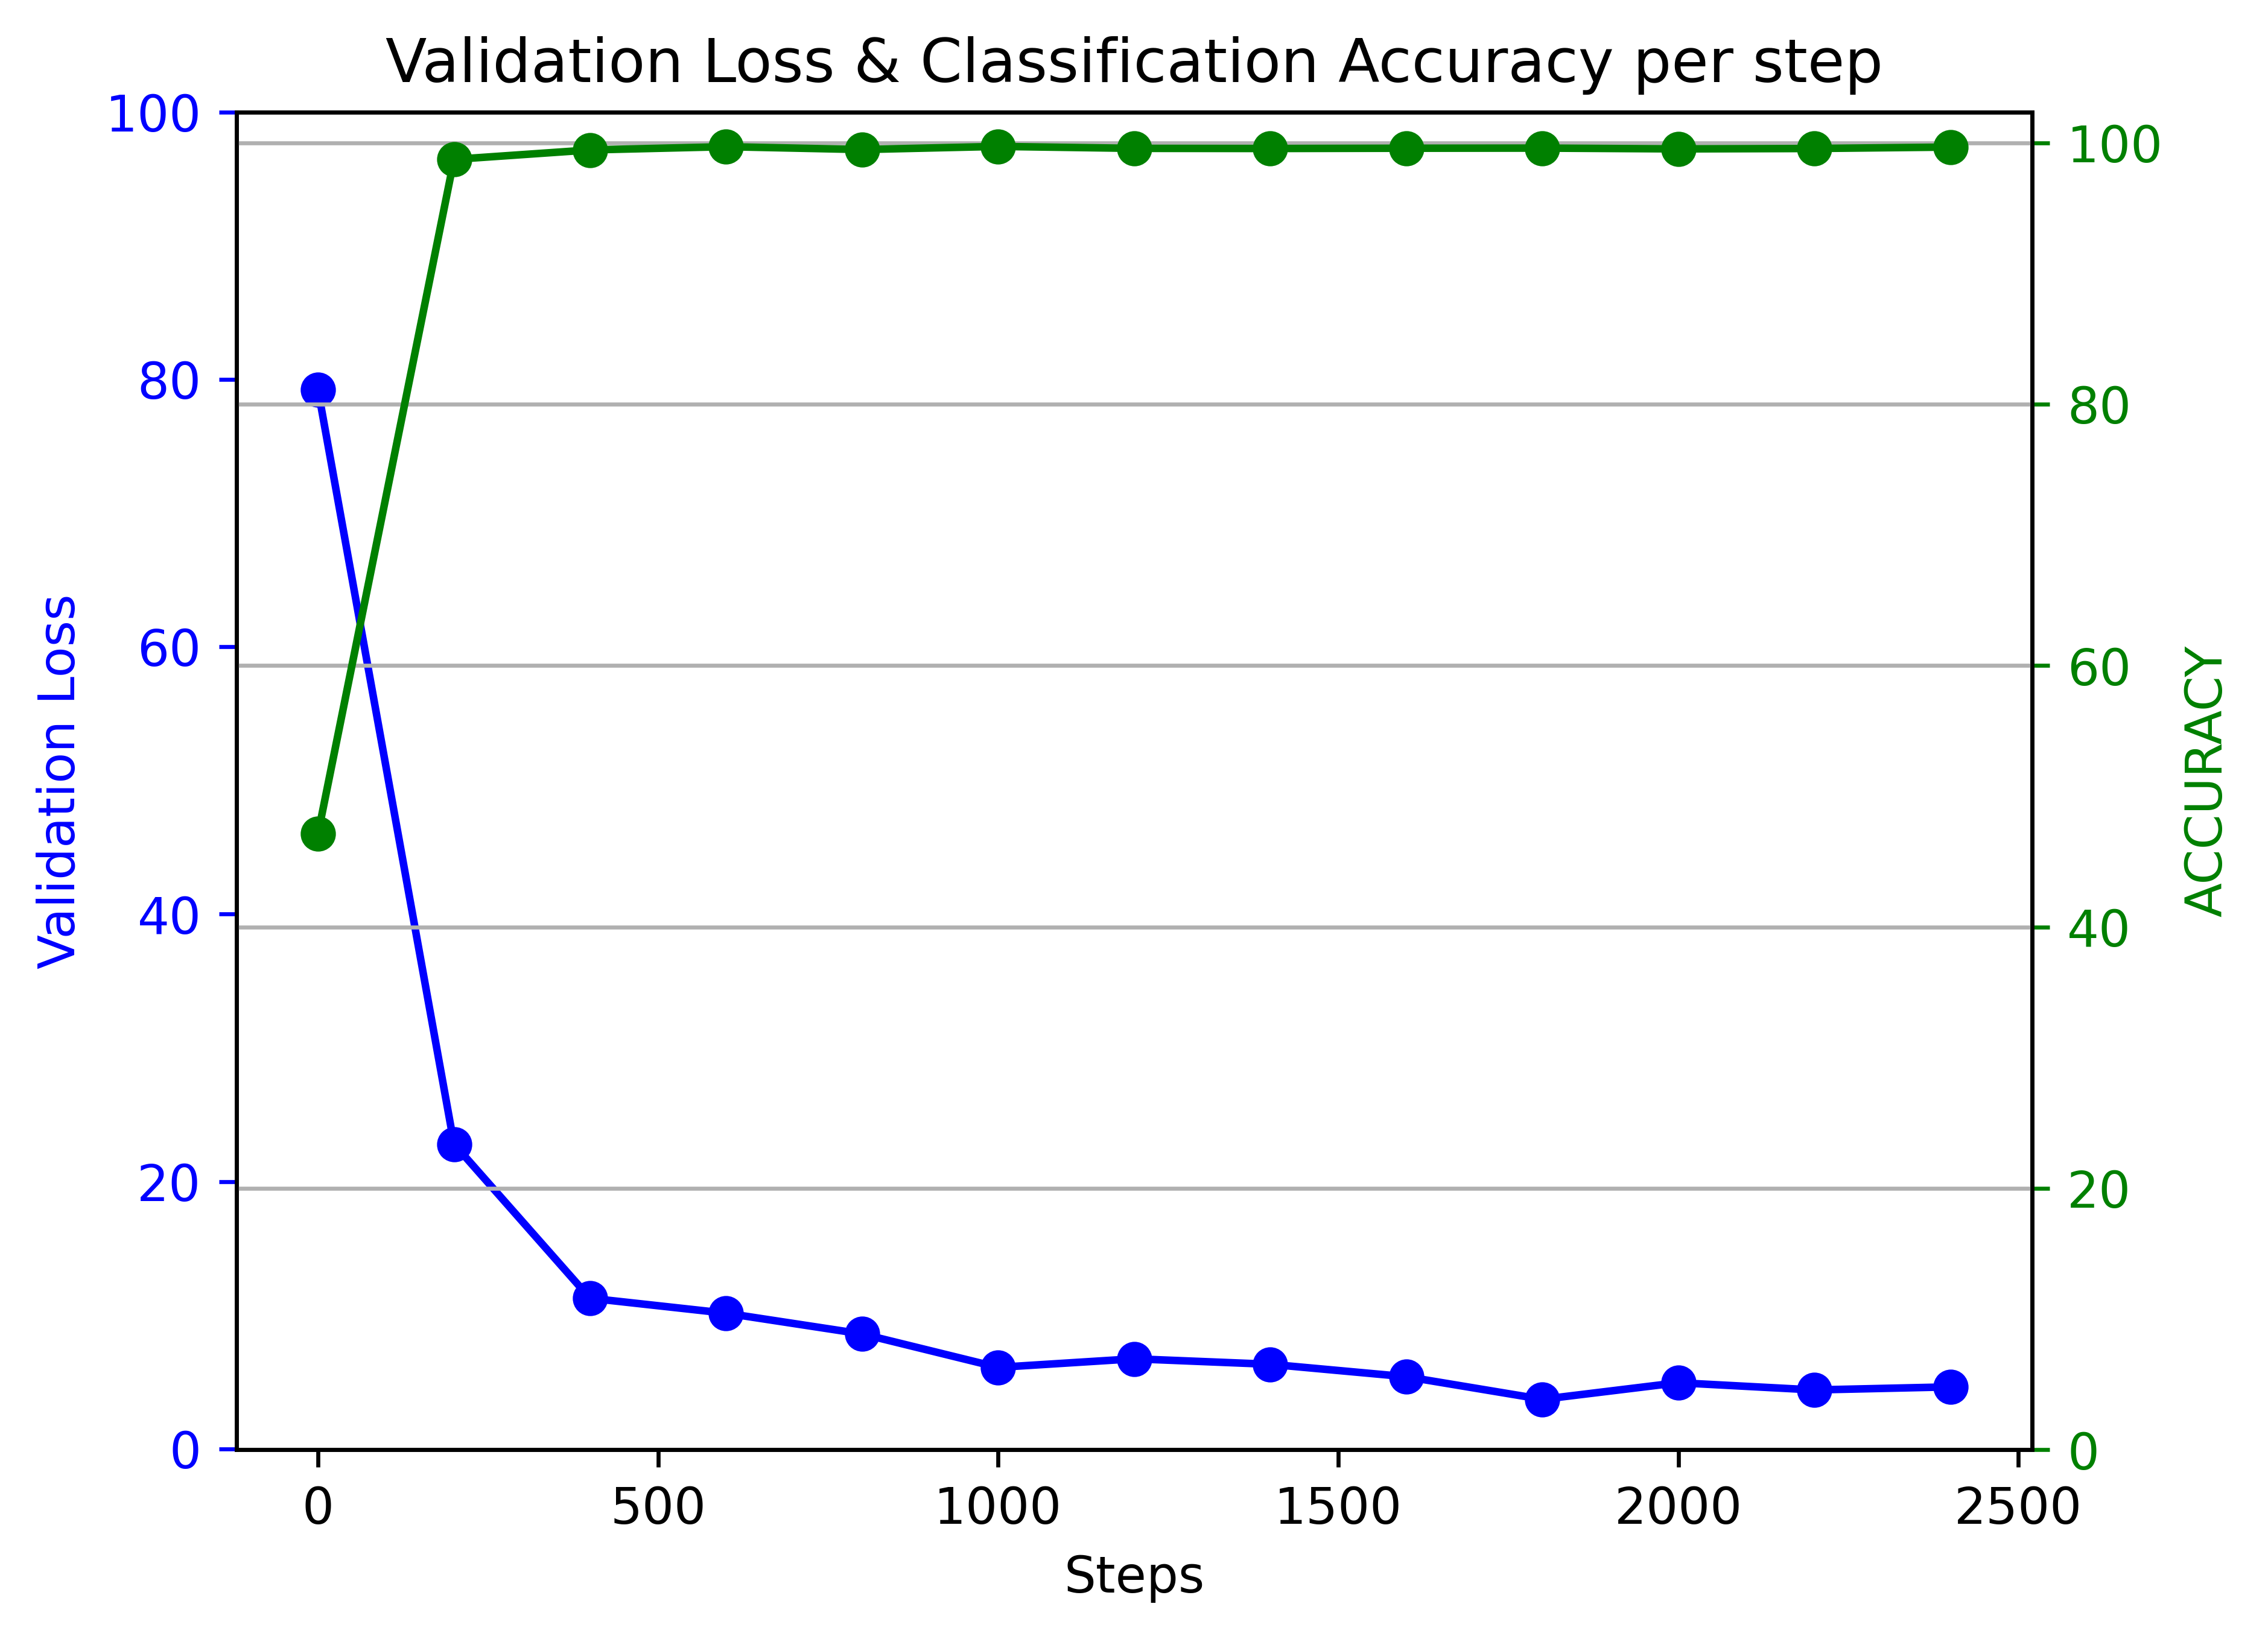

In [55]:
plt.figure(figsize = (16, 8))
fig, ax1 = plt.subplots(dpi = 300)

ax1.plot(result['#'], result['LOSS TEXTCAT_MULTILABEL'],  label = 'Validation Loss', marker = 'o', color = 'blue')
ax1.set_xlabel('Steps')
ax1.set_ylabel('Validation Loss', color = 'blue')
ax1.set_yticks(range(0, 110, 20))
ax1.tick_params('y', colors = 'blue')

ax2 = ax1.twinx()
ax2.plot(result['#'], result['CATS_SCORE'], label = 'SCORE', marker = 'o', color = 'green')
ax2.set_ylabel('ACCURACY', color = 'green')
ax2.set_yticks(range(0, 110, 20))
ax2.tick_params('y', colors = 'green')

plt.title('Validation Loss & Classification Accuracy per step')
plt.grid(True)
plt.show()

In [57]:
!python -m spacy evaluate output_game_1220/model-best/ --output ./output_game_1220/metrics.json ./data/valid.spacy --gpu-id 0

2023-12-20 06:02:15.897616: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 06:02:15.897663: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 06:02:15.898933: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 06:02:17.298866: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   99.73 
SPEED                 4697  


=========================== Textcat F (per label) =======

In [58]:
!python -m spacy evaluate output_game_1220/model-best/ --output ./output_game_1220/metrics_rmemoji.json ./data/valid_rmemoji.spacy --gpu-id 0

2023-12-20 06:03:21.763798: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 06:03:21.763852: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 06:03:21.765358: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 06:03:23.336244: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   99.75 
SPEED                 4591  


=========================== Textcat F (per label) =======

In [59]:
!python -m spacy evaluate output_game_1220/model-best/ --output ./output_game_1220/metrics_emoji2desc.json ./data/valid_emoji2desc.spacy --gpu-id 0

2023-12-20 06:04:26.580866: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 06:04:26.580917: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 06:04:26.582208: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 06:04:27.670416: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   99.73 
SPEED                 4991  


=========================== Textcat F (per label) =======

In [60]:
!python -m spacy evaluate output_game_1220/model-best/ --output ./output_game_1220/metrics_rmpunc.json ./data/valid_rmpunc.spacy --gpu-id 0

2023-12-20 06:05:33.291162: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-12-20 06:05:33.291217: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-12-20 06:05:33.292414: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-12-20 06:05:34.417749: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT
ℹ Using GPU: 0

================================== Results ==================================

TOK                   100.00
TEXTCAT (macro AUC)   99.67 
SPEED                 4612  


=========================== Textcat F (per label) =======

In [65]:
os.chdir('./output_game_1220')

In [63]:
score = get_json('./metrics.json')
score_rmemoji = get_json('./metrics_rmemoji.json')
score_emoji2desc = get_json('./metrics_emoji2desc.json')
score_rmpunc = get_json('./metrics_rmpunc.json')

In [66]:
p = ['cats_score', 'cats_macro_p', 'cats_macro_r', 'cats_macro_f']

performance_raw = pd.DataFrame({
    'SCORE': score[p[0]],
    'MARCO_P': score[p[1]],
    'MARCO_R': score[p[2]],
    'MARCO_F1': score[p[3]]
}, index = ['RAW'])

performance_rmemoji = pd.DataFrame({
    'SCORE': score_rmemoji[p[0]],
    'MARCO_P': score_rmemoji[p[1]],
    'MARCO_R': score_rmemoji[p[2]],
    'MARCO_F1': score_rmemoji[p[3]]
}, index = ['Remove Emoji'])

performance_emoji2desc = pd.DataFrame({
    'SCORE': score_emoji2desc[p[0]],
    'MARCO_P': score_emoji2desc[p[1]],
    'MARCO_R': score_emoji2desc[p[2]],
    'MARCO_F1': score_emoji2desc[p[3]]
}, index = ['Emoji to Description'])

performance_rmpunc = pd.DataFrame({
    'SCORE': score_rmpunc[p[0]],
    'MARCO_P': score_rmpunc[p[1]],
    'MARCO_R': score_rmpunc[p[2]],
    'MARCO_F1': score_rmpunc[p[3]]
}, index = ['Remove Punctuation'])

performance = pd.concat([performance_raw, performance_rmemoji, performance_emoji2desc, performance_rmpunc])
performance.index.name = 'METHOD'

In [68]:
performance.style.highlight_max(axis = 0, color = 'red').highlight_min(axis = 0, color = 'lightblue')

,SCORE,MARCO_P,MARCO_R,MARCO_F1
METHOD,,,,
RAW,0.997310,0.989710,0.987904,0.988775
Remove Emoji,0.997498,0.989833,0.983936,0.986800
Emoji to Description,0.997309,0.975564,0.969228,0.971669
Remove Punctuation,0.996718,0.987540,0.981985,0.984686


In [69]:
performance.to_csv('prf_cf_emoji.csv')

In [70]:
cats_f_per_type = score['cats_f_per_type']
df_cats_f_per_type = pd.DataFrame(cats_f_per_type).T
df_cats_f_per_type = df_cats_f_per_type.rename(columns = {'p': 'PRECISION', 'r': 'RECALL', 'f': 'F1'})

df_cats_f_per_type.index.name = 'CATEGORY'

In [71]:
df_cats_f_per_type.style.highlight_max(axis = 0, color = 'red').highlight_min(axis = 0, color = 'lightblue')

,PRECISION,RECALL,F1
CATEGORY,,,
球員,0.986697,0.989474,0.988083
教練,0.991828,0.992843,0.992335
裁判,0.992938,0.972337,0.982530
戰術,0.982363,0.994944,0.988614
球隊,0.994722,0.989920,0.992315


In [72]:
df_cats_f_per_type.to_csv('prf_cf_cats.csv')

In [73]:
cats_f_per_type_score = score['cats_f_per_type']
cats_f_per_type_rmemoji = score_rmemoji['cats_f_per_type']
cats_f_per_type_emoji2desc = score_emoji2desc['cats_f_per_type']
cats_f_per_type_rmpunc = score_rmpunc['cats_f_per_type']

df_cats_f_per_type_score = pd.DataFrame(cats_f_per_type_score).T
df_cats_f_per_type_rmemoji = pd.DataFrame(cats_f_per_type_rmemoji).T
df_cats_f_per_type_emoji2desc = pd.DataFrame(cats_f_per_type_emoji2desc).T
df_cats_f_per_type_rmpunc = pd.DataFrame(cats_f_per_type_rmpunc).T

df_cats_f_per_type_score = df_cats_f_per_type_score.rename(columns={'f': 'RAW'})
df_cats_f_per_type_rmemoji = df_cats_f_per_type_rmemoji.rename(columns={'f': 'Remove Emoji'})
df_cats_f_per_type_emoji2desc = df_cats_f_per_type_emoji2desc.rename(columns={'f': 'Emoji to Description'})
df_cats_f_per_type_rmpunc = df_cats_f_per_type_rmpunc.rename(columns={'f': 'Remove punctuation'})

df_cats = pd.concat([df_cats_f_per_type_score[['RAW']], df_cats_f_per_type_rmemoji[['Remove Emoji']], df_cats_f_per_type_emoji2desc[['Emoji to Description']], df_cats_f_per_type_rmpunc[['Remove punctuation']]], axis = 1)
df_cats.index.name = 'F1 score'

In [74]:
df_cats.style.highlight_max(axis = 1, color = 'red').highlight_min(axis = 1, color = 'lightblue')

,RAW,Remove Emoji,Emoji to Description,Remove punctuation
F1 score,,,,
球員,0.988083,0.989294,0.971426,0.984757
教練,0.992335,0.992335,0.991313,0.992335
裁判,0.982530,0.983736,0.970211,0.978281
戰術,0.988614,0.988790,0.984508,0.988625
球隊,0.992315,0.979844,0.940885,0.979433


In [75]:
df_cats.to_csv('f1_cf_cats_emoji.csv')